# Facial images preprocessing

In this notebook I'll apply some OpenCV functions in order to crop faces in images. First part contains easy examples step by step. Second part joins the desired operations for batch processing an entire image set for further Convolutional Neural Network training.

## Imports

In [0]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np

from fastai.vision import *

np.random.seed(42)

In [0]:
%%capture
from notebook import notebookapp
server = list(notebookapp.list_running_servers())[0]

if server['hostname'] == 'localhost':
    # Local environment
    from cv2 import imshow as cv2_imshow
    %reload_ext autoreload
    %autoreload 2
    %matplotlib inline
else:
    # Cloud
    from google.colab.patches import cv2_imshow as cv2_imshow

In [0]:
from fastai.utils.show_install import *
show_install()

## Single Image Processing

### Image loading

First we unzip our images just uploaded if we are in the cloud:

In [0]:
! unzip faces.zip

Load an image as example:

In [0]:
face_img = cv2.imread('data/faces/cn/w/00000007.jpg', cv2.COLOR_BGR2RGB) # nice example

In [6]:
type(face_img), face_img.shape

(numpy.ndarray, (200, 200, 3))

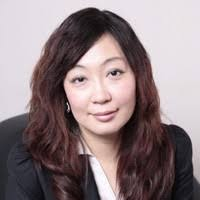

In [7]:
cv2_imshow(face_img)

Show the green channel only:

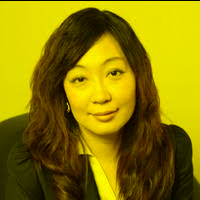

In [8]:
face_img[0,:,:] = 0
face_img[:,:,0] = 0
cv2_imshow(face_img)

### Greyscale version

In order to avoid color *distractions* in facial image classification it could be a good idea to use black and white versions (or maybe not! you can always try both).

In [0]:
face_img = cv2.imread('data/faces/cn/w/00000007.jpg', 0)
# face_img = cv2.imread('data/faces/cn/w/00000002.jpg', 0) # mouth detected as eye (use haarcascade_eye_tree_eyeglasses.xml)
# face_img = cv2.imread('data/faces/cn/w/00000019.jpg', 0) # lateral pose; eye not detected
# face_img = cv2.imread('data/faces/cn/w/00000020.jpg', 0) # glasses; eye not detected

In [10]:
face_orig = face_img.copy()
type(face_img), face_img.shape

(numpy.ndarray, (200, 200))

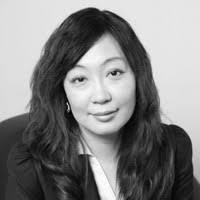

In [11]:
cv2_imshow(face_img)

### Face detection

We'd like to do apply face detection in order to validate and straighten images. We'll use the [Haar Feature-based Cascade Classifier for Object Detection](https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html) included in OpenCV for this.

First we choose the pre-trained classifiers for facial and eyes detection.

For **face detection**, OpenCV offers these ones (from the more relaxed to the more strict):
* *haarcascade_frontalface_default.xml*
* haarcascade_frontalface_alt2.xml
* haarcascade_frontalface_alt.xml
* haarcascade_frontalface_alt_tree.xml

For **eyes detection**, we can choose between two:
* *haarcascade_eye_tree_eyeglasses.xml* (works well with glasses!)
* haarcascade_eye.xml

We cant test several combinations. Have in mind that there isn't one working better for all images.


In [0]:
# load pre-trained classifier
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
# eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_alt.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')


We try to detect faces in our photo first:

In [13]:
face_detect = face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=5)
print(f'Faces found: {len(face_detect)}')

Faces found: 1


Now we try to detect the eyes:

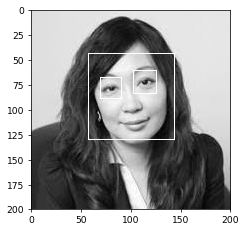

In [14]:
eye_pos = []

if len(face_detect):
    # face rectangle
    (x, y, w, h) = face_detect[0]
    cv2.rectangle(face_img, (x, y), (x+w, y+h), (255, 0, 0), 1);
    # eyes
    eyes = eyes_cascade.detectMultiScale(face_img[y:y+h, x:x+w])
    for (ex, ey, ew, eh) in eyes:
        eye_pos.append(x+ex+ew/2)
        eye_pos.append(y+ey+eh/2)
        cv2.rectangle(face_img, (x+ex, y+ey), (x+ex+ew, y+ey+eh), (255, 255, 255), 1)

    plt.figure(figsize=(4,4), dpi=66)
    plt.imshow(face_img, cmap='gray')

If we don't detect both eyes maybe we should discard the sample, because we couldn't know if the face is straight or not.

### Face alignment

We can straighten a face if we calculate the angle between both eyes:

In [15]:
eye_pos

[113.5, 72.5, 79.5, 78.5]

In [16]:
angle = math.degrees(math.atan2(eye_pos[1]-eye_pos[3], eye_pos[0]-eye_pos[2]))
angle

-10.007979801441337

We rotate the picture for the eyes to be aligned:

In [0]:
rows,cols = face_orig.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2), angle, 1)
face_rot = cv2.warpAffine(face_orig,M,(cols,rows))

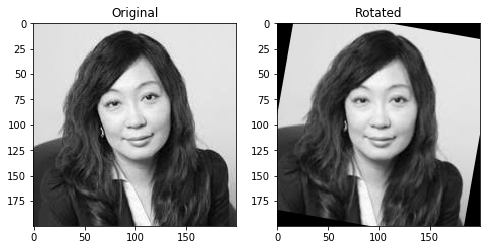

In [18]:
plt.figure(figsize=(8,4))
plt.subplot(121), plt.imshow(face_orig, cmap='gray'), plt.title('Original');
plt.subplot(122), plt.imshow(face_rot, cmap='gray'), plt.title('Rotated');

### Face cropping

In order to help our future neural network to classify faces, is necessary to get rid of external things, like the background, clothes, or accesories. As we'll try to classify faces by gender and nationality, the cropped rectangle could be different for each purpose. For genders it could be a good idea to embrace a larger area, as opposite to the case of nationalities,  (well, it depends on the number of classes we take into account... we can mix men and women or not).

First thing we need is getting the face rectangle again (as we rotated the image, the rectangle rotated too):

In [19]:
face_detect = face_cascade.detectMultiScale(face_rot, scaleFactor=1.1, minNeighbors=5)
print(f'Faces found: {len(face_detect)}')

Faces found: 1


Here comes the interesting part. We'll use a padding to enlarge the rectangle as much as we want. Finally, we crop the image using those measures and save that to a file:

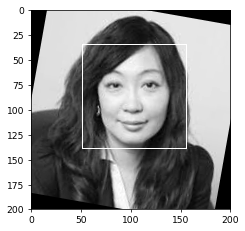

In [20]:
if len(face_detect):
    # face rectangle
    (x, y, w, h) = face_detect[0]

    # padding
    p = math.ceil(h/10)

    cv2.rectangle(face_rot, (x-p, y-p), (x+w+p, y+h+p), (255, 0, 0), 1);

    plt.figure(figsize=(4,4), dpi=66)
    plt.imshow(face_rot, cmap='gray')

    # cropping (add 1 to the origin to avoid the rectangle)
    cv2.imwrite('crop.jpg', face_rot[y-p+1:y+h+p, x-p+1:x+w+p])

In [21]:
face_crop = cv2.imread('crop.jpg', 0)
type(face_crop), face_crop.shape

(numpy.ndarray, (103, 103))

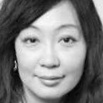

In [22]:
cv2_imshow(face_crop)

### Image resizing

Neural networks need that all input images have the same size in a training stage. We can resize them on the fly, but it's not a good idea, since it would mean a lot of resizings for each file in training time. So better we do it before.

Here, we test different downscaling and upscaling methods included in OpenCV:

In [0]:
# help(cv2.resize)

In [0]:
def cv2_resize(original, size, interpolation):
    return cv2.resize(original, (size, size), interpolation=interpolation)

#### Downscaling

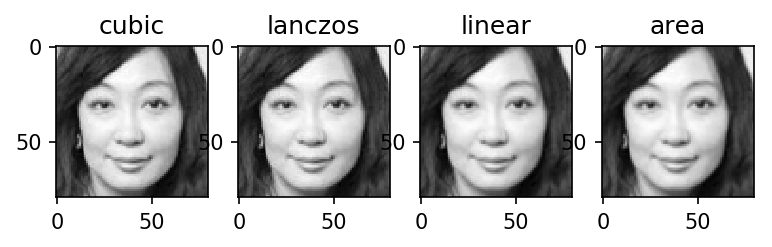

In [25]:
plt.figure(dpi=150)
plt.subplot(141), plt.imshow(cv2_resize(face_crop, 80, cv2.INTER_CUBIC), cmap='gray'), plt.title('cubic');
plt.subplot(142), plt.imshow(cv2_resize(face_crop, 80, cv2.INTER_LANCZOS4), cmap='gray'), plt.title('lanczos');
plt.subplot(143), plt.imshow(cv2_resize(face_crop, 80, cv2.INTER_LINEAR), cmap='gray'), plt.title('linear');
plt.subplot(144), plt.imshow(cv2_resize(face_crop, 80, cv2.INTER_AREA), cmap='gray'), plt.title('area');

#### Upscaling

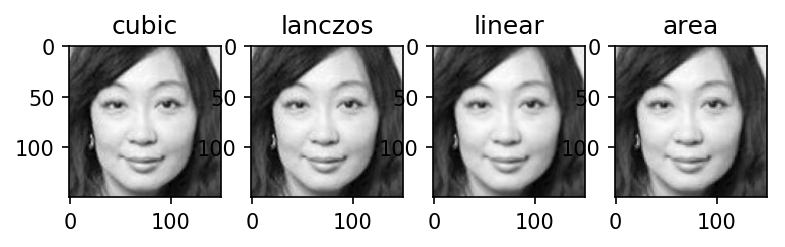

In [26]:
plt.figure(dpi=150)
plt.subplot(141), plt.imshow(cv2_resize(face_crop, 150, cv2.INTER_CUBIC), cmap='gray'), plt.title('cubic');
plt.subplot(142), plt.imshow(cv2_resize(face_crop, 150, cv2.INTER_LANCZOS4), cmap='gray'), plt.title('lanczos');
plt.subplot(143), plt.imshow(cv2_resize(face_crop, 150, cv2.INTER_LINEAR), cmap='gray'), plt.title('linear');
plt.subplot(144), plt.imshow(cv2_resize(face_crop, 150, cv2.INTER_AREA), cmap='gray'), plt.title('area');

Slight differences appreciated between them. We'll use the linear method, which is more recommended for greyscale images (and seems smoother with less noise)

### Normalization

We can use the [`normalize()`](https://docs.opencv.org/4.1.0/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd) function to apply visual normalization to fix very dark pictures, or too much light ones. We can even fix low contrast.

NOTE: If we don't set `vmin` and `vmax` parameters in `imshow()`, we get the normalized visualization of the image!

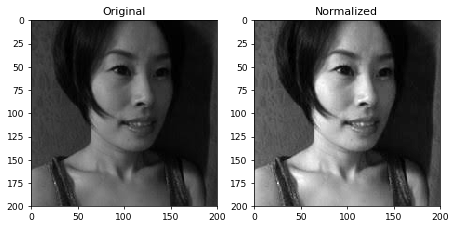

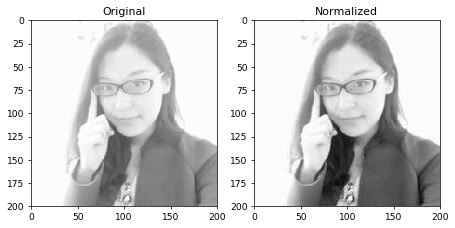

In [31]:
face_imgs = [cv2.imread('data/faces/cn/w/00000094.jpg', 0), # dark
             cv2.imread('data/faces/cn/w/00001920.jpg', 0)] # low contrast

for face_img in face_imgs:
    norm_img = np.zeros((200, 200))
    norm_img = cv2.normalize(face_img, norm_img, 0, 255, cv2.NORM_MINMAX)

    plt.figure(figsize=(8, 4), dpi=66)
    plt.subplot(121), plt.imshow(face_img, cmap='gray', vmin=0, vmax=255), plt.title('Original');
    plt.subplot(122), plt.imshow(norm_img, cmap='gray', vmin=0, vmax=255), plt.title('Normalized');

NOTE: When using images as input for Convolutional Neural Networks, there is no need to apply a normalization of this kind (one that seems good to our eyes). In [practice](http://cs231n.github.io/neural-networks-2/#datapre) we'll zero-center the data and maybe normalize every pixel as well.

## Batch Processing

In this section we apply every interesting piece we saw before in batch mode :)

### Rotating and cropping

In [0]:
img_path = Path('data/faces')
crop_path = Path('data/face_crops')
! rm -r {crop_path}
crop_path.mkdir(parents=True, exist_ok=False)
crop_path

PosixPath('data/face_crops')

We use all available classifiers for face/eyes detection, because we don't want to discard valid samples. 

In a previous test we proved that's the better option:


- alt + eye: 1233
- alt2 + eye: 1259
- alt_tree + eye: 572
- default + eye: 1221


- alt2 + eyeglasses: 812
- alt + eyeglasses: 853
- default + eyeglasses: 822


- combined: 1405

In [0]:
face_cascades = [cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt2.xml'),
                 cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'),
                 cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt_tree.xml'),
                 cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')]
eyes_cascades = [cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml'),
                 cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')]

We write functions this time :)

In [0]:
def detect_face(face_img):
    for face_cascade in face_cascades:
        face = face_cascade.detectMultiScale(face_img, scaleFactor=1.1, minNeighbors=5)
        if len(face) == 1:
            return face[0]

def detect_eyes(face_rectangle):
    for eyes_cascade in eyes_cascades:
        eyes = eyes_cascade.detectMultiScale(face_rectangle)
        if len(eyes) == 2:
            return eyes

In [0]:
def rotate_image(face_img, eyes):
    
    eye_pos = []
    for (ex, ey, ew, eh) in eyes:
        eye_pos.append(x+ex+ew/2)
        eye_pos.append(y+ey+eh/2)
                
    if eye_pos[0] < eye_pos[2]:
        angle = math.degrees(math.atan2(eye_pos[3]-eye_pos[1], eye_pos[2]-eye_pos[0]))
    else:
        angle = math.degrees(math.atan2(eye_pos[1]-eye_pos[3], eye_pos[0]-eye_pos[2]))
    
    # angle threshold
    if abs(angle) > 40:
        return
    
    rows, cols = face_img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    
    return cv2.warpAffine(face_img, M, (cols,rows))

In [0]:
def process_image(f, dest_folder):
    
    # image loading
    face_img = cv2.imread(str(f), 0)

    # face detection
    face = detect_face(face_img)
    if face is None:
        return
    
    (x, y, w, h) = face
    
    # eyes detection
    eyes = detect_eyes(face_img[y:y+h, x:x+w])
    if eyes is None:
        return
    
    # rotation
    face_rot = rotate_image(face_img, eyes)
    if face_rot is None:
        return
    
    # face detection again for cropping
    face = detect_face(face_rot)
    if face is None:
        return
    
    (x, y, w, h) = face
    
    # padding (using this for gender differentiation could be good)
    p = 0 # math.ceil(h/10)
    
    # cropping
    face_crop = face_rot[y-p+1:y+h+p, x-p+1:x+w+p]
    
    # file saving, with a size threshold
    if face_crop.shape[0] > 66:
        cv2.imwrite(str(dest_folder/f.name), face_crop)

Execute the batch process that get the face crops:

In [0]:
nationalities = ['cn', 'jp', 'kr']
genders = ['m', 'w']

for n in nationalities:
    for g in genders:
        folder = crop_path/n/g
        folder.mkdir(parents=True, exist_ok=True)
        fnames = get_image_files(img_path/n/g, recurse=True)
        
        for f in fnames:
            process_image(f, crop_path/n/g)
        
        #verify_images(crop_path/n/g, delete=True)

Zip the image for backup:

In [0]:
! zip -r face_crops.zip data/face_crops

### Resizing with Pillow

We use Pillow for resizing, since it seems to be faster:

In [0]:
# # Uncomment this if you upload the crops in a zip file
# ! rm -r data/face_crops
# ! unzip face_crops.zip

In [0]:
! rm -r {path_80}
! rm -r {path_112}
! rm -r {path_140}

rm: cannot remove '{path_80}': No such file or directory
rm: cannot remove '{path_112}': No such file or directory
rm: cannot remove '{path_140}': No such file or directory


This code is partly borrowed from **fastai** docs:

In [0]:
path_80 = Path('data/face_crops_80')
path_112 = Path('data/face_crops_112')
path_140 = Path('data/face_crops_140')

il = ImageList.from_folder(crop_path)

def resize_one(fn, i, path, size):
    try:
        dest = path/fn.relative_to(crop_path)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, size, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR)#.convert('RGB')
        img.save(dest, quality=90)#90
    except:
        pass

# create smaller image sets the first time this nb is run
sets = [(path_80, 80), (path_112, 112), (path_140, 140)]
for p, size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

Zip the images for backup:

In [0]:
! zip -r face_crops_resized.zip data/face_crops_*